In [39]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

In [40]:
!python -V

Python 3.12.9


In [41]:
%pip install pyarrow

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [42]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:c:/Users/PALMPAY/MLOPS-ZOOMCAMP/03-training/mlruns/1', creation_time=1745637809492, experiment_id='1', last_update_time=1745637809492, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [43]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [44]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [45]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime - df.lpep_pickup_datetime        

0       0 days 00:03:56
1       0 days 00:08:45
2       0 days 00:05:58
3       0 days 00:07:05
4       0 days 00:00:04
              ...      
76513   0 days 00:38:00
76514   0 days 00:38:00
76515   0 days 00:11:00
76516   0 days 00:27:00
76517   0 days 00:10:00
Length: 76518, dtype: timedelta64[us]

### Checking the distribution of trip duration

In [46]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)


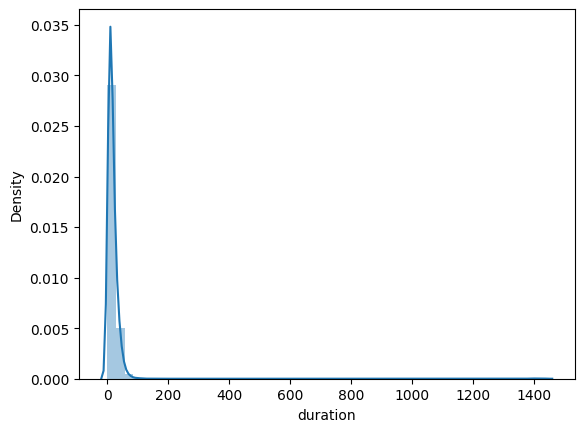

In [47]:
sns.distplot(df.duration)
plt.show()

In [48]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [49]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [50]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99]).mean

<bound method Series.mean of count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64>

In [51]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [52]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.827368941909368

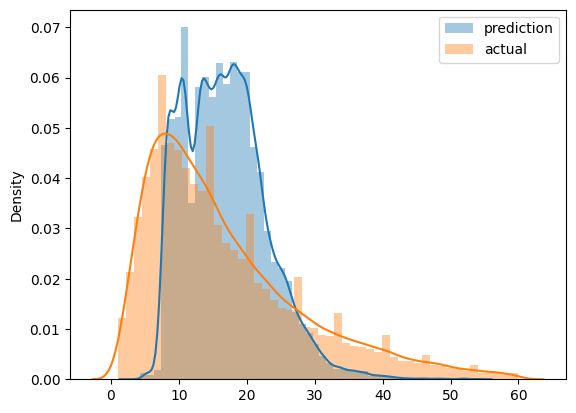

In [53]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [54]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [55]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [56]:
len(df_train), len(df_val)



(73908, 61921)

In [57]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [58]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [59]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203341164

In [61]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [62]:

with mlflow.start_run():
    
    mlflow.set_tag("developer", "Isaac")
    
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet" )
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet" )
    
    alpha=0.01
    
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse=mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [63]:
import xgboost as xgb

In [64]:
train = xgb.DMatrix(X_train, label=y_train)
valid=xgb.DMatrix(X_val, label=y_val)

In [65]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [66]:

def objective(params):
    
    with mlflow.start_run():
        
        mlflow.set_tag("developer", "Isaac")
        
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=200,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        
        return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[0]	validation-rmse:8.95076                           
[1]	validation-rmse:7.58192                           
[2]	validation-rmse:7.04885                           
[3]	validation-rmse:6.83610                           
[4]	validation-rmse:6.73671                           
[5]	validation-rmse:6.68697                           
[6]	validation-rmse:6.65764                           
[7]	validation-rmse:6.63860                           
[8]	validation-rmse:6.62719                           
[9]	validation-rmse:6.61946                           
[10]	validation-rmse:6.61294                          
[11]	validation-rmse:6.60804                          
[12]	validation-rmse:6.60556                          
[13]	validation-rmse:6.60155                          
[14]	validation-rmse:6.59988                          
[15]	validation-rmse:6.59593                          
[16]	validation-rmse:6.59453                          
[17]	validation-rmse:6.59224                          
[18]	valid

  2%|▏         | 1/50 [01:42<1:23:50, 102.66s/trial, best loss: 42.93891151004729]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 42.938912


[0]	validation-rmse:10.96785                                                      
[1]	validation-rmse:9.98274                                                       
[2]	validation-rmse:9.21175                                                       
[3]	validation-rmse:8.61509                                                       
[4]	validation-rmse:8.15734                                                       
[5]	validation-rmse:7.80993                                                       
[6]	validation-rmse:7.54467                                                       
[7]	validation-rmse:7.34463                                                       
[8]	validation-rmse:7.19427                                                       
[9]	validation-rmse:7.08089                                                       
[10]	validation-rmse:6.99532                                                      
[11]	validation-rmse:6.92810                                                      
[12]

  4%|▍         | 2/50 [03:13<1:16:23, 95.49s/trial, best loss: 42.93891151004729] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 42.938912


[0]	validation-rmse:8.52306                                                      
[1]	validation-rmse:7.27366                                                      
[2]	validation-rmse:6.87033                                                      
[3]	validation-rmse:6.73120                                                      
[4]	validation-rmse:6.67590                                                      
[5]	validation-rmse:6.64721                                                      
[6]	validation-rmse:6.63565                                                      
[7]	validation-rmse:6.62492                                                      
[8]	validation-rmse:6.62125                                                      
[9]	validation-rmse:6.61762                                                      
[10]	validation-rmse:6.61127                                                     
[11]	validation-rmse:6.60451                                                     
[12]	validation-

  6%|▌         | 3/50 [05:36<1:31:58, 117.41s/trial, best loss: 41.52015264429441]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 41.520153


[0]	validation-rmse:10.31047                                                      
[1]	validation-rmse:9.01390                                                       
[2]	validation-rmse:8.15182                                                       
[3]	validation-rmse:7.59309                                                       
[4]	validation-rmse:7.22893                                                       
[5]	validation-rmse:6.99244                                                       
[6]	validation-rmse:6.84403                                                       
[7]	validation-rmse:6.74533                                                       
[8]	validation-rmse:6.67643                                                       
[9]	validation-rmse:6.62703                                                       
[10]	validation-rmse:6.59332                                                      
[11]	validation-rmse:6.56784                                                      
[12]

  8%|▊         | 4/50 [07:54<1:36:06, 125.36s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 40.320216


[0]	validation-rmse:10.61028                                                      
[1]	validation-rmse:9.44449                                                       
[2]	validation-rmse:8.61218                                                       
[3]	validation-rmse:8.02884                                                       
[4]	validation-rmse:7.62562                                                       
[5]	validation-rmse:7.34633                                                       
[6]	validation-rmse:7.15484                                                       
[7]	validation-rmse:7.02437                                                       
[8]	validation-rmse:6.93350                                                       
[9]	validation-rmse:6.86697                                                       
[10]	validation-rmse:6.81874                                                      
[11]	validation-rmse:6.78260                                                      
[12]

 10%|█         | 5/50 [10:21<1:39:52, 133.18s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 40.320216


[0]	validation-rmse:11.47785                                                      
[1]	validation-rmse:10.83214                                                      
[2]	validation-rmse:10.26461                                                      
[3]	validation-rmse:9.76540                                                       
[4]	validation-rmse:9.33524                                                       
[5]	validation-rmse:8.96090                                                       
[6]	validation-rmse:8.63306                                                       
[7]	validation-rmse:8.34786                                                       
[8]	validation-rmse:8.10205                                                       
[9]	validation-rmse:7.89122                                                       
[10]	validation-rmse:7.70872                                                      
[11]	validation-rmse:7.55374                                                      
[12]

 12%|█▏        | 6/50 [15:23<2:19:46, 190.61s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004874 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 40.320216


[0]	validation-rmse:7.96467                                                       
[1]	validation-rmse:6.95827                                                       
[2]	validation-rmse:6.72237                                                       
[3]	validation-rmse:6.64704                                                       
[4]	validation-rmse:6.61381                                                       
[5]	validation-rmse:6.60062                                                       
[6]	validation-rmse:6.59510                                                       
[7]	validation-rmse:6.58881                                                       
[8]	validation-rmse:6.58458                                                       
[9]	validation-rmse:6.58184                                                       
[10]	validation-rmse:6.57676                                                      
[11]	validation-rmse:6.57390                                                      
[12]

 14%|█▍        | 7/50 [21:18<2:55:16, 244.57s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003452 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 40.320216


[0]	validation-rmse:11.70982                                                      
[1]	validation-rmse:11.24660                                                      
[2]	validation-rmse:10.82115                                                      
[3]	validation-rmse:10.43097                                                      
[4]	validation-rmse:10.07347                                                      
[5]	validation-rmse:9.74539                                                       
[6]	validation-rmse:9.44749                                                       
[7]	validation-rmse:9.17561                                                       
[8]	validation-rmse:8.92794                                                       
[9]	validation-rmse:8.70269                                                       
[10]	validation-rmse:8.49760                                                      
[11]	validation-rmse:8.31261                                                      
[12]

 16%|█▌        | 8/50 [24:40<2:41:35, 230.86s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004441 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 40.320216


[0]	validation-rmse:8.77187                                                       
[1]	validation-rmse:7.45292                                                       
[2]	validation-rmse:6.98005                                                       
[3]	validation-rmse:6.79876                                                       
[4]	validation-rmse:6.72577                                                       
[5]	validation-rmse:6.69384                                                       
[6]	validation-rmse:6.67908                                                       
[7]	validation-rmse:6.66777                                                       
[8]	validation-rmse:6.66259                                                       
[9]	validation-rmse:6.65971                                                       
[10]	validation-rmse:6.65224                                                      
[11]	validation-rmse:6.64973                                                      
[12]

 18%|█▊        | 9/50 [26:16<2:08:52, 188.61s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010954 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 40.320216


[0]	validation-rmse:8.46032                                                       
[1]	validation-rmse:7.21556                                                       
[2]	validation-rmse:6.80954                                                       
[3]	validation-rmse:6.66345                                                       
[4]	validation-rmse:6.60244                                                       
[5]	validation-rmse:6.57459                                                       
[6]	validation-rmse:6.55601                                                       
[7]	validation-rmse:6.53969                                                       
[8]	validation-rmse:6.53655                                                       
[9]	validation-rmse:6.53124                                                       
[10]	validation-rmse:6.52601                                                      
[11]	validation-rmse:6.52246                                                      
[12]

 20%|██        | 10/50 [30:10<2:15:10, 202.77s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004136 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 40.320216


[0]	validation-rmse:7.05882                                                        
[1]	validation-rmse:6.73880                                                        
[2]	validation-rmse:6.69129                                                        
[3]	validation-rmse:6.67056                                                        
[4]	validation-rmse:6.66525                                                        
[5]	validation-rmse:6.65638                                                        
[6]	validation-rmse:6.64895                                                        
[7]	validation-rmse:6.64509                                                        
[8]	validation-rmse:6.63986                                                        
[9]	validation-rmse:6.63540                                                        
[10]	validation-rmse:6.63068                                                       
[11]	validation-rmse:6.62701                                                

 22%|██▏       | 11/50 [31:29<1:47:14, 164.98s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009601 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 40.320216


[0]	validation-rmse:11.58206                                                       
[1]	validation-rmse:11.01741                                                       
[2]	validation-rmse:10.50945                                                       
[3]	validation-rmse:10.05576                                                       
[4]	validation-rmse:9.65341                                                        
[5]	validation-rmse:9.29508                                                        
[6]	validation-rmse:8.97908                                                        
[7]	validation-rmse:8.69591                                                        
[8]	validation-rmse:8.44633                                                        
[9]	validation-rmse:8.22310                                                        
[10]	validation-rmse:8.03216                                                       
[11]	validation-rmse:7.86260                                                

 24%|██▍       | 12/50 [35:20<1:57:11, 185.04s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004817 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 40.320216


[0]	validation-rmse:11.65596                                                       
[1]	validation-rmse:11.14851                                                       
[2]	validation-rmse:10.68782                                                       
[3]	validation-rmse:10.27012                                                       
[4]	validation-rmse:9.89176                                                        
[5]	validation-rmse:9.55013                                                        
[6]	validation-rmse:9.24155                                                        
[7]	validation-rmse:8.96362                                                        
[8]	validation-rmse:8.71381                                                        
[9]	validation-rmse:8.49032                                                        
[10]	validation-rmse:8.28989                                                       
[11]	validation-rmse:8.11099                                                

 26%|██▌       | 13/50 [37:18<1:41:31, 164.65s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010060 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 40.320216


[0]	validation-rmse:11.39419                                                       
[1]	validation-rmse:10.68520                                                       
[2]	validation-rmse:10.07181                                                       
[3]	validation-rmse:9.54134                                                        
[4]	validation-rmse:9.08862                                                        
[5]	validation-rmse:8.70013                                                        
[6]	validation-rmse:8.36868                                                        
[7]	validation-rmse:8.08468                                                        
[8]	validation-rmse:7.85036                                                        
[9]	validation-rmse:7.64979                                                        
[10]	validation-rmse:7.47946                                                       
[11]	validation-rmse:7.33898                                                

 28%|██▊       | 14/50 [46:14<2:46:08, 276.91s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004004 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 40.320216


[0]	validation-rmse:10.83697                                                       
[1]	validation-rmse:9.77550                                                        
[2]	validation-rmse:8.96102                                                        
[3]	validation-rmse:8.35391                                                        
[4]	validation-rmse:7.90121                                                        
[5]	validation-rmse:7.56167                                                        
[6]	validation-rmse:7.31460                                                        
[7]	validation-rmse:7.13006                                                        
[8]	validation-rmse:6.99355                                                        
[9]	validation-rmse:6.89152                                                        
[10]	validation-rmse:6.81511                                                       
[11]	validation-rmse:6.75786                                                

 30%|███       | 15/50 [47:54<2:10:18, 223.40s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 40.320216


[0]	validation-rmse:9.66613                                                        
[1]	validation-rmse:8.24229                                                        
[2]	validation-rmse:7.46872                                                        
[3]	validation-rmse:7.06564                                                        
[4]	validation-rmse:6.85365                                                        
[5]	validation-rmse:6.72752                                                        
[6]	validation-rmse:6.66152                                                        
[7]	validation-rmse:6.62140                                                        
[8]	validation-rmse:6.59706                                                        
[9]	validation-rmse:6.57759                                                        
[10]	validation-rmse:6.56561                                                       
[11]	validation-rmse:6.55579                                                

 32%|███▏      | 16/50 [52:44<2:17:56, 243.44s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 40.320216


[0]	validation-rmse:9.86075                                                        
[1]	validation-rmse:8.46317                                                        
[2]	validation-rmse:7.66717                                                        
[3]	validation-rmse:7.22469                                                        
[4]	validation-rmse:6.98391                                                        
[5]	validation-rmse:6.84439                                                        
[6]	validation-rmse:6.76303                                                        
[7]	validation-rmse:6.71124                                                        
[8]	validation-rmse:6.68077                                                        
[9]	validation-rmse:6.66002                                                        
[10]	validation-rmse:6.64816                                                       
[11]	validation-rmse:6.63927                                                

 34%|███▍      | 17/50 [53:45<1:43:48, 188.74s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004491 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 40.320216


[0]	validation-rmse:6.86620                                                        
[1]	validation-rmse:6.75100                                                        
[2]	validation-rmse:6.73571                                                        
[3]	validation-rmse:6.72877                                                        
[4]	validation-rmse:6.71948                                                        
[5]	validation-rmse:6.70123                                                        
[6]	validation-rmse:6.69180                                                        
[7]	validation-rmse:6.69118                                                        
[8]	validation-rmse:6.68632                                                        
[9]	validation-rmse:6.68370                                                        
[10]	validation-rmse:6.68083                                                       
[11]	validation-rmse:6.68180                                                

 36%|███▌      | 18/50 [57:01<1:41:50, 190.94s/trial, best loss: 40.32021560682383]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 40.320216


[0]	validation-rmse:10.50682                                                       
[1]	validation-rmse:9.27516                                                        
[2]	validation-rmse:8.40138                                                        
[3]	validation-rmse:7.79705                                                        
[4]	validation-rmse:7.38385                                                        
[5]	validation-rmse:7.10228                                                        
[6]	validation-rmse:6.91126                                                        
[7]	validation-rmse:6.77792                                                        
[8]	validation-rmse:6.68870                                                        
[9]	validation-rmse:6.62181                                                        
[10]	validation-rmse:6.57563                                                       
[11]	validation-rmse:6.54212                                                

 38%|███▊      | 19/50 [1:00:46<1:43:50, 201.00s/trial, best loss: 40.11989623882937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007759 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 40.119896


[0]	validation-rmse:9.50504                                                          
[1]	validation-rmse:8.09286                                                          
[2]	validation-rmse:7.39891                                                          
[3]	validation-rmse:7.06214                                                          
[4]	validation-rmse:6.90142                                                          
[5]	validation-rmse:6.81058                                                          
[6]	validation-rmse:6.76070                                                          
[7]	validation-rmse:6.73361                                                          
[8]	validation-rmse:6.71718                                                          
[9]	validation-rmse:6.70497                                                          
[10]	validation-rmse:6.69738                                                         
[11]	validation-rmse:6.69230                          

 40%|████      | 20/50 [1:01:41<1:18:32, 157.09s/trial, best loss: 40.11989623882937]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 40.119896


[0]	validation-rmse:11.26528                                                         
[1]	validation-rmse:10.47125                                                         
[2]	validation-rmse:9.80763                                                          
[3]	validation-rmse:9.25886                                                          
[4]	validation-rmse:8.80617                                                          
[5]	validation-rmse:8.43757                                                          
[6]	validation-rmse:8.13595                                                          
[7]	validation-rmse:7.89283                                                          
[8]	validation-rmse:7.69421                                                          
[9]	validation-rmse:7.53162                                                          
[10]	validation-rmse:7.40092                                                         
[11]	validation-rmse:7.29496                          

 42%|████▏     | 21/50 [1:02:23<59:20, 122.79s/trial, best loss: 40.11989623882937]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004378 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 40.119896


[0]	validation-rmse:10.24564                                                       
[1]	validation-rmse:8.92250                                                        
[2]	validation-rmse:8.05228                                                        
[3]	validation-rmse:7.49946                                                        
[4]	validation-rmse:7.15154                                                        
[5]	validation-rmse:6.92565                                                        
[6]	validation-rmse:6.78284                                                        
[7]	validation-rmse:6.68983                                                        
[8]	validation-rmse:6.62701                                                        
[9]	validation-rmse:6.58134                                                        
[10]	validation-rmse:6.55162                                                       
[11]	validation-rmse:6.52770                                                

 44%|████▍     | 22/50 [1:05:29<1:06:01, 141.50s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003779 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 40.035290


[0]	validation-rmse:10.18794                                                         
[1]	validation-rmse:8.84509                                                          
[2]	validation-rmse:7.97633                                                          
[3]	validation-rmse:7.43497                                                          
[4]	validation-rmse:7.09562                                                          
[5]	validation-rmse:6.88335                                                          
[6]	validation-rmse:6.75049                                                          
[7]	validation-rmse:6.66478                                                          
[8]	validation-rmse:6.60784                                                          
[9]	validation-rmse:6.56922                                                          
[10]	validation-rmse:6.54284                                                         
[11]	validation-rmse:6.52392                          

 46%|████▌     | 23/50 [1:07:58<1:04:46, 143.96s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005900 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 40.035290


[0]	validation-rmse:11.81005                                                         
[1]	validation-rmse:11.43280                                                         
[2]	validation-rmse:11.08023                                                         
[3]	validation-rmse:10.75081                                                         
[4]	validation-rmse:10.44330                                                         
[5]	validation-rmse:10.15632                                                         
[6]	validation-rmse:9.88883                                                          
[7]	validation-rmse:9.63974                                                          
[8]	validation-rmse:9.40802                                                          
[9]	validation-rmse:9.19254                                                          
[10]	validation-rmse:8.99286                                                         
[11]	validation-rmse:8.80727                          

 48%|████▊     | 24/50 [1:13:13<1:24:36, 195.26s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 40.035290


[0]	validation-rmse:11.16374                                                         
[1]	validation-rmse:10.29243                                                         
[2]	validation-rmse:9.57374                                                          
[3]	validation-rmse:8.98256                                                          
[4]	validation-rmse:8.50195                                                          
[5]	validation-rmse:8.11231                                                          
[6]	validation-rmse:7.79896                                                          
[7]	validation-rmse:7.54929                                                          
[8]	validation-rmse:7.34653                                                          
[9]	validation-rmse:7.18643                                                          
[10]	validation-rmse:7.05682                                                         
[11]	validation-rmse:6.95242                          

 50%|█████     | 25/50 [1:16:12<1:19:18, 190.32s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 40.035290


[0]	validation-rmse:10.69121                                                         
[1]	validation-rmse:9.54307                                                          
[2]	validation-rmse:8.69050                                                          
[3]	validation-rmse:8.06673                                                          
[4]	validation-rmse:7.61601                                                          
[5]	validation-rmse:7.29216                                                          
[6]	validation-rmse:7.06017                                                          
[7]	validation-rmse:6.89574                                                          
[8]	validation-rmse:6.77883                                                          
[9]	validation-rmse:6.69388                                                          
[10]	validation-rmse:6.63042                                                         
[11]	validation-rmse:6.58267                          

 52%|█████▏    | 26/50 [1:21:17<1:29:51, 224.63s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 40.035290


[0]	validation-rmse:10.93067                                                         
[1]	validation-rmse:9.91376                                                          
[2]	validation-rmse:9.11657                                                          
[3]	validation-rmse:8.49539                                                          
[4]	validation-rmse:8.02188                                                          
[5]	validation-rmse:7.65850                                                          
[6]	validation-rmse:7.38222                                                          
[7]	validation-rmse:7.17377                                                          
[8]	validation-rmse:7.01404                                                          
[9]	validation-rmse:6.89424                                                          
[10]	validation-rmse:6.80315                                                         
[11]	validation-rmse:6.73184                          

 54%|█████▍    | 27/50 [1:24:58<1:25:44, 223.66s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 40.035290


[0]	validation-rmse:11.20948                                                         
[1]	validation-rmse:10.36806                                                         
[2]	validation-rmse:9.66660                                                          
[3]	validation-rmse:9.08564                                                          
[4]	validation-rmse:8.60755                                                          
[5]	validation-rmse:8.21650                                                          
[6]	validation-rmse:7.89830                                                          
[7]	validation-rmse:7.63995                                                          
[8]	validation-rmse:7.43154                                                          
[9]	validation-rmse:7.26384                                                          
[10]	validation-rmse:7.12703                                                         
[11]	validation-rmse:7.01800                          

 56%|█████▌    | 28/50 [1:27:05<1:11:22, 194.68s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004401 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 40.035290


[0]	validation-rmse:9.92456                                                          
[1]	validation-rmse:8.50965                                                          
[2]	validation-rmse:7.66445                                                          
[3]	validation-rmse:7.17968                                                          
[4]	validation-rmse:6.90082                                                          
[5]	validation-rmse:6.73384                                                          
[6]	validation-rmse:6.63742                                                          
[7]	validation-rmse:6.57612                                                          
[8]	validation-rmse:6.53530                                                          
[9]	validation-rmse:6.50855                                                          
[10]	validation-rmse:6.48998                                                         
[11]	validation-rmse:6.47620                          

 58%|█████▊    | 29/50 [1:30:42<1:10:28, 201.35s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004003 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 40.035290


[0]	validation-rmse:7.51688                                                          
[1]	validation-rmse:6.79111                                                          
[2]	validation-rmse:6.64378                                                          
[3]	validation-rmse:6.60299                                                          
[4]	validation-rmse:6.57975                                                          
[5]	validation-rmse:6.56675                                                          
[6]	validation-rmse:6.56114                                                          
[7]	validation-rmse:6.55466                                                          
[8]	validation-rmse:6.55168                                                          
[9]	validation-rmse:6.54714                                                          
[10]	validation-rmse:6.54397                                                         
[11]	validation-rmse:6.54158                          

 60%|██████    | 30/50 [1:32:54<1:00:10, 180.53s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009041 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 40.035290


[0]	validation-rmse:10.66928                                                         
[1]	validation-rmse:9.51106                                                          
[2]	validation-rmse:8.65724                                                          
[3]	validation-rmse:8.03488                                                          
[4]	validation-rmse:7.59103                                                          
[5]	validation-rmse:7.27084                                                          
[6]	validation-rmse:7.04548                                                          
[7]	validation-rmse:6.88861                                                          
[8]	validation-rmse:6.77432                                                          
[9]	validation-rmse:6.69202                                                          
[10]	validation-rmse:6.63256                                                         
[11]	validation-rmse:6.58673                          

 62%|██████▏   | 31/50 [1:37:03<1:03:41, 201.11s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006152 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 40.035290


[0]	validation-rmse:9.23337                                                          
[1]	validation-rmse:7.80871                                                          
[2]	validation-rmse:7.16842                                                          
[3]	validation-rmse:6.87356                                                          
[4]	validation-rmse:6.73673                                                          
[5]	validation-rmse:6.66296                                                          
[6]	validation-rmse:6.62901                                                          
[7]	validation-rmse:6.60693                                                          
[8]	validation-rmse:6.59147                                                          
[9]	validation-rmse:6.57938                                                          
[10]	validation-rmse:6.57314                                                         
[11]	validation-rmse:6.56943                          

 64%|██████▍   | 32/50 [1:40:41<1:01:49, 206.09s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008662 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 40.035290


[0]	validation-rmse:11.15246                                                         
[1]	validation-rmse:10.27713                                                         
[2]	validation-rmse:9.55854                                                          
[3]	validation-rmse:8.96949                                                          
[4]	validation-rmse:8.48909                                                          
[5]	validation-rmse:8.11252                                                          
[6]	validation-rmse:7.80306                                                          
[7]	validation-rmse:7.56165                                                          
[8]	validation-rmse:7.35866                                                          
[9]	validation-rmse:7.20866                                                          
[10]	validation-rmse:7.08328                                                         
[11]	validation-rmse:6.98638                          

 66%|██████▌   | 33/50 [1:46:09<1:08:44, 242.60s/trial, best loss: 40.03529047107307]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004764 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 40.035290


[0]	validation-rmse:10.16983                                                         
[1]	validation-rmse:8.81682                                                          
[2]	validation-rmse:7.94726                                                          
[3]	validation-rmse:7.40304                                                          
[4]	validation-rmse:7.06318                                                          
[5]	validation-rmse:6.85392                                                          
[6]	validation-rmse:6.72185                                                          
[7]	validation-rmse:6.63705                                                          
[8]	validation-rmse:6.58141                                                          
[9]	validation-rmse:6.54291                                                          
[10]	validation-rmse:6.51355                                                         
[11]	validation-rmse:6.49373                          

 68%|██████▊   | 34/50 [1:49:49<1:02:57, 236.08s/trial, best loss: 39.9221502603427] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008047 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 39.922150


[0]	validation-rmse:10.09605                                                        
[1]	validation-rmse:8.72166                                                         
[2]	validation-rmse:7.85830                                                         
[3]	validation-rmse:7.32986                                                         
[4]	validation-rmse:7.00716                                                         
[5]	validation-rmse:6.81388                                                         
[6]	validation-rmse:6.69351                                                         
[7]	validation-rmse:6.61549                                                         
[8]	validation-rmse:6.56507                                                         
[9]	validation-rmse:6.53056                                                         
[10]	validation-rmse:6.50486                                                        
[11]	validation-rmse:6.48634                                     

 70%|███████   | 35/50 [1:53:46<59:04, 236.28s/trial, best loss: 39.9221502603427]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010002 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 39.922150


[0]	validation-rmse:7.77263                                                       
[1]	validation-rmse:6.80327                                                       
[2]	validation-rmse:6.58716                                                       
[3]	validation-rmse:6.52063                                                       
[4]	validation-rmse:6.49848                                                       
[5]	validation-rmse:6.49594                                                       
[6]	validation-rmse:6.48737                                                       
[7]	validation-rmse:6.47684                                                       
[8]	validation-rmse:6.46771                                                       
[9]	validation-rmse:6.46190                                                       
[10]	validation-rmse:6.45712                                                      
[11]	validation-rmse:6.44995                                                      
[12]

 72%|███████▏  | 36/50 [1:56:39<50:40, 217.17s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007996 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 39.922150


[0]	validation-rmse:9.96814                                                       
[1]	validation-rmse:8.55364                                                       
[2]	validation-rmse:7.69404                                                       
[3]	validation-rmse:7.18696                                                       
[4]	validation-rmse:6.89185                                                       
[5]	validation-rmse:6.71783                                                       
[6]	validation-rmse:6.61527                                                       
[7]	validation-rmse:6.54875                                                       
[8]	validation-rmse:6.50558                                                       
[9]	validation-rmse:6.47672                                                       
[10]	validation-rmse:6.45869                                                      
[11]	validation-rmse:6.44459                                                      
[12]

 74%|███████▍  | 37/50 [2:01:29<51:49, 239.21s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009975 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 39.922150


[0]	validation-rmse:9.10643                                                       
[1]	validation-rmse:7.69091                                                       
[2]	validation-rmse:7.08988                                                       
[3]	validation-rmse:6.82520                                                       
[4]	validation-rmse:6.70280                                                       
[5]	validation-rmse:6.64245                                                       
[6]	validation-rmse:6.61391                                                       
[7]	validation-rmse:6.59431                                                       
[8]	validation-rmse:6.58724                                                       
[9]	validation-rmse:6.57789                                                       
[10]	validation-rmse:6.56922                                                      
[11]	validation-rmse:6.56343                                                      
[12]

 76%|███████▌  | 38/50 [2:06:16<50:41, 253.42s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 39.922150


[0]	validation-rmse:8.35913                                                       
[1]	validation-rmse:7.16657                                                       
[2]	validation-rmse:6.81392                                                       
[3]	validation-rmse:6.69695                                                       
[4]	validation-rmse:6.64209                                                       
[5]	validation-rmse:6.61553                                                       
[6]	validation-rmse:6.60326                                                       
[7]	validation-rmse:6.59484                                                       
[8]	validation-rmse:6.59153                                                       
[9]	validation-rmse:6.58367                                                       
[10]	validation-rmse:6.58042                                                      
[11]	validation-rmse:6.57649                                                      
[12]

 78%|███████▊  | 39/50 [2:09:48<44:09, 240.86s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009298 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 39.922150


[0]	validation-rmse:10.43818                                                      
[1]	validation-rmse:9.18442                                                       
[2]	validation-rmse:8.31871                                                       
[3]	validation-rmse:7.72967                                                       
[4]	validation-rmse:7.33702                                                       
[5]	validation-rmse:7.07655                                                       
[6]	validation-rmse:6.90430                                                       
[7]	validation-rmse:6.78592                                                       
[8]	validation-rmse:6.70715                                                       
[9]	validation-rmse:6.64980                                                       
[10]	validation-rmse:6.60847                                                      
[11]	validation-rmse:6.58033                                                      
[12]

 80%|████████  | 40/50 [2:12:31<36:15, 217.56s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010001 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss 39.922150


[0]	validation-rmse:10.95373                                                      
[1]	validation-rmse:9.95331                                                       
[2]	validation-rmse:9.16649                                                       
[3]	validation-rmse:8.55290                                                       
[4]	validation-rmse:8.08010                                                       
[5]	validation-rmse:7.71963                                                       
[6]	validation-rmse:7.44497                                                       
[7]	validation-rmse:7.23488                                                       
[8]	validation-rmse:7.07738                                                       
[9]	validation-rmse:6.95582                                                       
[10]	validation-rmse:6.86485                                                      
[11]	validation-rmse:6.79394                                                      
[12]

 82%|████████▏ | 41/50 [2:14:17<27:37, 184.18s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009012 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss 39.922150


[0]	validation-rmse:9.47883                                                       
[1]	validation-rmse:8.05061                                                       
[2]	validation-rmse:7.33928                                                       
[3]	validation-rmse:6.99422                                                       
[4]	validation-rmse:6.80431                                                       
[5]	validation-rmse:6.71339                                                       
[6]	validation-rmse:6.66120                                                       
[7]	validation-rmse:6.63009                                                       
[8]	validation-rmse:6.60976                                                       
[9]	validation-rmse:6.59410                                                       
[10]	validation-rmse:6.58539                                                      
[11]	validation-rmse:6.57802                                                      
[12]

 84%|████████▍ | 42/50 [2:17:53<25:48, 193.62s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008680 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss 39.922150


[0]	validation-rmse:11.33549                                                      
[1]	validation-rmse:10.57920                                                      
[2]	validation-rmse:9.93291                                                       
[3]	validation-rmse:9.38008                                                       
[4]	validation-rmse:8.91141                                                       
[5]	validation-rmse:8.51503                                                       
[6]	validation-rmse:8.17981                                                       
[7]	validation-rmse:7.89908                                                       
[8]	validation-rmse:7.66413                                                       
[9]	validation-rmse:7.46797                                                       
[10]	validation-rmse:7.30445                                                      
[11]	validation-rmse:7.16857                                                      
[12]

 86%|████████▌ | 43/50 [2:24:53<30:31, 261.68s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003009 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss 39.922150


[0]	validation-rmse:7.08811                                                       
[1]	validation-rmse:6.58117                                                       
[2]	validation-rmse:6.51549                                                       
[3]	validation-rmse:6.49819                                                       
[4]	validation-rmse:6.48896                                                       
[5]	validation-rmse:6.48223                                                       
[6]	validation-rmse:6.47609                                                       
[7]	validation-rmse:6.46920                                                       
[8]	validation-rmse:6.46373                                                       
[9]	validation-rmse:6.45679                                                       
[10]	validation-rmse:6.45180                                                      
[11]	validation-rmse:6.44844                                                      
[12]

 88%|████████▊ | 44/50 [2:28:38<25:04, 250.69s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009999 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss 39.922150


[0]	validation-rmse:8.72569                                                       
[1]	validation-rmse:7.40354                                                       
[2]	validation-rmse:6.93900                                                       
[3]	validation-rmse:6.76824                                                       
[4]	validation-rmse:6.69866                                                       
[5]	validation-rmse:6.66354                                                       
[6]	validation-rmse:6.64713                                                       
[7]	validation-rmse:6.63517                                                       
[8]	validation-rmse:6.63279                                                       
[9]	validation-rmse:6.62716                                                       
[10]	validation-rmse:6.62474                                                      
[11]	validation-rmse:6.62088                                                      
[12]

 90%|█████████ | 45/50 [2:31:09<18:22, 220.60s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss 39.922150


[0]	validation-rmse:8.13549                                                       
[1]	validation-rmse:6.98406                                                       
[2]	validation-rmse:6.67028                                                       
[3]	validation-rmse:6.56986                                                       
[4]	validation-rmse:6.52852                                                       
[5]	validation-rmse:6.51083                                                       
[6]	validation-rmse:6.49617                                                       
[7]	validation-rmse:6.49190                                                       
[8]	validation-rmse:6.48700                                                       
[9]	validation-rmse:6.47981                                                       
[10]	validation-rmse:6.47371                                                      
[11]	validation-rmse:6.46720                                                      
[12]

 92%|█████████▏| 46/50 [2:33:27<13:03, 195.80s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004746 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss 39.922150


[0]	validation-rmse:11.03481                                                      
[1]	validation-rmse:10.08811                                                      
[2]	validation-rmse:9.33263                                                       
[3]	validation-rmse:8.73666                                                       
[4]	validation-rmse:8.26998                                                       
[5]	validation-rmse:7.90683                                                       
[6]	validation-rmse:7.62729                                                       
[7]	validation-rmse:7.41109                                                       
[8]	validation-rmse:7.24482                                                       
[9]	validation-rmse:7.11599                                                       
[10]	validation-rmse:7.01571                                                      
[11]	validation-rmse:6.93746                                                      
[12]

 94%|█████████▍| 47/50 [2:35:53<09:03, 181.05s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008003 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss 39.922150


[0]	validation-rmse:10.20301                                                      
[1]	validation-rmse:8.88141                                                       
[2]	validation-rmse:8.03670                                                       
[3]	validation-rmse:7.50930                                                       
[4]	validation-rmse:7.18548                                                       
[5]	validation-rmse:6.97814                                                       
[6]	validation-rmse:6.85200                                                       
[7]	validation-rmse:6.76522                                                       
[8]	validation-rmse:6.70971                                                       
[9]	validation-rmse:6.67336                                                       
[10]	validation-rmse:6.64693                                                      
[11]	validation-rmse:6.62735                                                      
[12]

 96%|█████████▌| 48/50 [2:38:31<05:48, 174.15s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss 39.922150


[0]	validation-rmse:11.53009                                                      
[1]	validation-rmse:10.92403                                                      
[2]	validation-rmse:10.38507                                                      
[3]	validation-rmse:9.90755                                                       
[4]	validation-rmse:9.48318                                                       
[5]	validation-rmse:9.11546                                                       
[6]	validation-rmse:8.78921                                                       
[7]	validation-rmse:8.50119                                                       
[8]	validation-rmse:8.25280                                                       
[9]	validation-rmse:8.03281                                                       
[10]	validation-rmse:7.84479                                                      
[11]	validation-rmse:7.68217                                                      
[12]

 98%|█████████▊| 49/50 [2:45:17<04:03, 243.74s/trial, best loss: 39.9221502603427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss 39.922150


[0]	validation-rmse:11.76876                                                      
[1]	validation-rmse:11.35537                                                      
[2]	validation-rmse:10.97047                                                      
[3]	validation-rmse:10.61396                                                      
[4]	validation-rmse:10.28317                                                      
[5]	validation-rmse:9.97675                                                       
[6]	validation-rmse:9.69226                                                       
[7]	validation-rmse:9.43087                                                       
[8]	validation-rmse:9.18756                                                       
[9]	validation-rmse:8.96443                                                       
[10]	validation-rmse:8.75726                                                      
[11]	validation-rmse:8.56726                                                      
[12]

100%|██████████| 50/50 [2:51:54<00:00, 206.29s/trial, best loss: 39.9221502603427]


In [68]:

# 7. Define parameters
params = {
    "learning_rate": 0.24829694351090045,
    "max_depth": 66,
    "min_child_weight": 1.7446418874456788,
    "objective": "reg:linear",
    "reg_alpha": 0.021452311464473947,
    "reg_lambda": 0.16422224950785752,
    "seed": 42
}

# 8. Train the model with MLflow tracking
with mlflow.start_run():
    # Set tags
    mlflow.set_tag("developer", "Isaac")

   # Log parameters 
    mlflow.log_params(params)
    
    # Train model
    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=50,
        evals=[(valid, "validation")],
        early_stopping_rounds=3
    )


[0]	validation-rmse:10.24791
[1]	validation-rmse:8.91555
[2]	validation-rmse:8.04212
[3]	validation-rmse:7.48198
[4]	validation-rmse:7.12487
[5]	validation-rmse:6.89993
[6]	validation-rmse:6.75271
[7]	validation-rmse:6.66003
[8]	validation-rmse:6.59747
[9]	validation-rmse:6.55255
[10]	validation-rmse:6.52025
[11]	validation-rmse:6.49507
[12]	validation-rmse:6.47941
[13]	validation-rmse:6.46711
[14]	validation-rmse:6.45500
[15]	validation-rmse:6.44664
[16]	validation-rmse:6.44157
[17]	validation-rmse:6.43807
[18]	validation-rmse:6.43379
[19]	validation-rmse:6.43108
[20]	validation-rmse:6.42853
[21]	validation-rmse:6.42619
[22]	validation-rmse:6.42390
[23]	validation-rmse:6.42130
[24]	validation-rmse:6.41897
[25]	validation-rmse:6.41697
[26]	validation-rmse:6.41413
[27]	validation-rmse:6.41231
[28]	validation-rmse:6.41092
[29]	validation-rmse:6.40915
[30]	validation-rmse:6.40745
[31]	validation-rmse:6.40458
[32]	validation-rmse:6.40265
[33]	validation-rmse:6.40073
[34]	validation-rmse:6.